In [1]:
import pandas as pd
import networkx as nx
import community
from collections import defaultdict
import csv
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Create Network

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
from collections import defaultdict

# 1. Load paper-organization relationships
df_paper_org = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/paper_organization.csv")

# 2. Initialize an undirected graph for co-organization
G_coorg = nx.Graph()

# 3. Add all organizations as nodes first
unique_orgs = df_paper_org["organization_id"].unique()
G_coorg.add_nodes_from(unique_orgs)

# 4. Group by paper to get a list of organizations for each paper
paper_groups = df_paper_org.groupby("paper_id")["organization_id"].apply(list)

# 5. For each paper, add edges between all pairs of organizations if multiple exist
for paper, orgs in paper_groups.items():
    if len(orgs) < 2:
        continue
    for i in range(len(orgs)):
        for j in range(i + 1, len(orgs)):
            o1, o2 = orgs[i], orgs[j]
            if G_coorg.has_edge(o1, o2):
                G_coorg[o1][o2]["weight"] += 1
            else:
                G_coorg.add_edge(o1, o2, weight=1)

# 6. Optionally, add organization names as node attributes
df_org = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/organization.csv")
org_names = dict(zip(df_org["node_id"], df_org["name"]))
nx.set_node_attributes(G_coorg, org_names, "name")

# Print basic info about the co-organization network
print("Co-Organization Network:")
print("Number of organization nodes:", G_coorg.number_of_nodes())
print("Number of co-organization links:", G_coorg.number_of_edges())

# Example: Print first 5 edges with weights
print("\nSample of co-organization edges with weights:")
for edge in list(G_coorg.edges(data=True))[:5]:
    print(edge)

Co-Organization Network:
Number of organization nodes: 3669
Number of co-organization links: 14572

Sample of co-organization edges with weights:
('organization_1', 'organization_2', {'weight': 1})
('organization_2', 'organization_28', {'weight': 1})
('organization_2', 'organization_185', {'weight': 1})
('organization_2', 'organization_186', {'weight': 1})
('organization_2', 'organization_187', {'weight': 1})


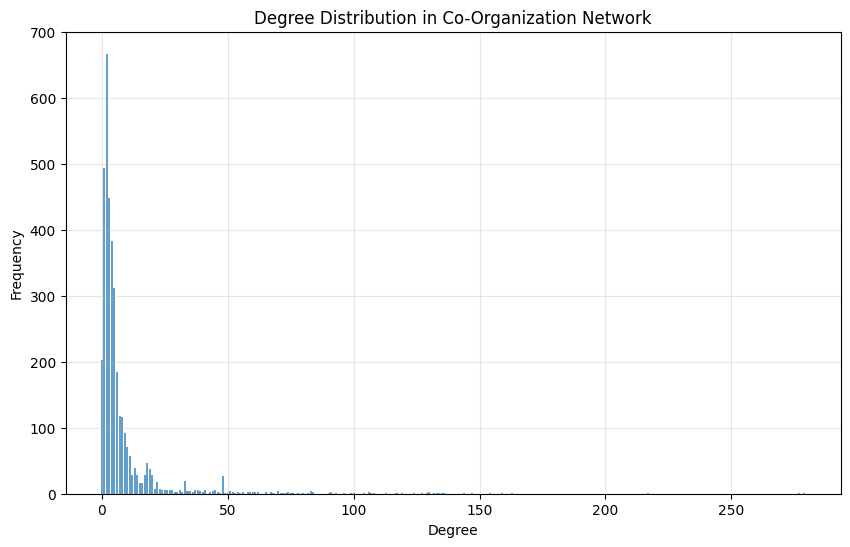


Degree Statistics:
Average degree: 7.94
Maximum degree: 279
Minimum degree: 0


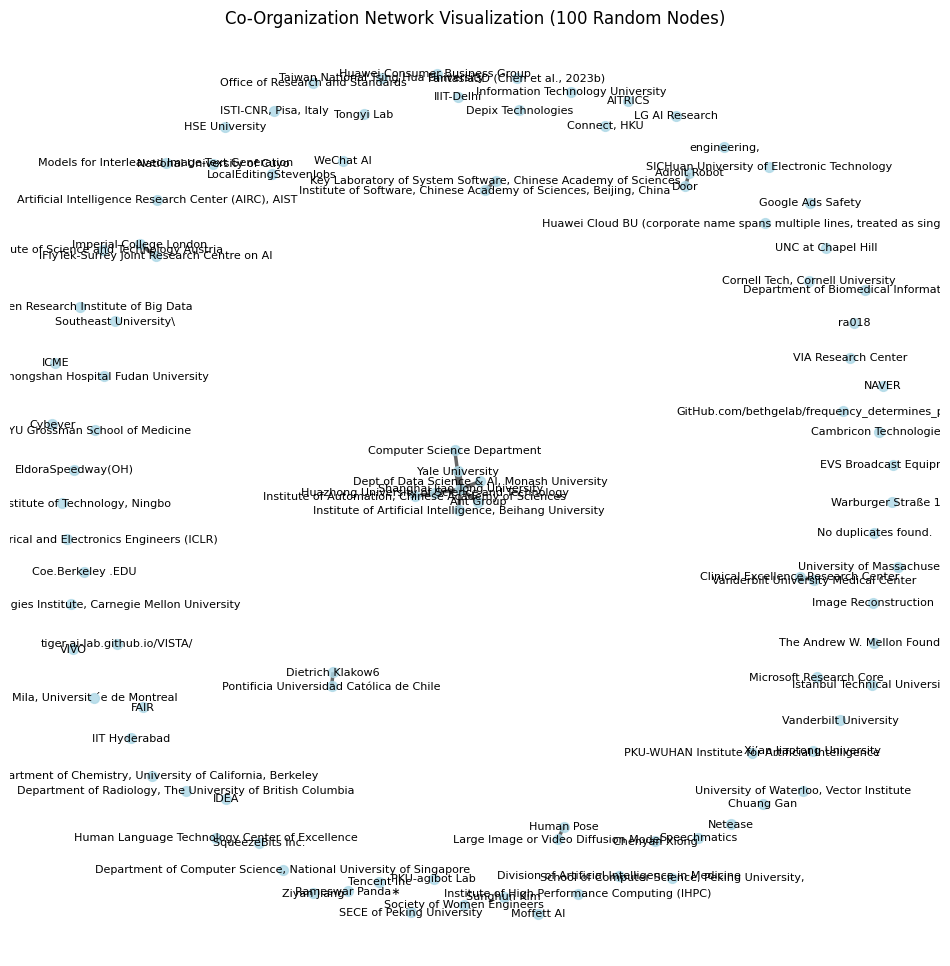

In [4]:
# Degree distribution
degrees = [d for _, d in G_coorg.degree()]
degree_counts = pd.Series(degrees).value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(degree_counts.index, degree_counts.values, alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution in Co-Organization Network')
plt.grid(True, alpha=0.3)
plt.show()

print("\nDegree Statistics:")
print(f"Average degree: {sum(degrees)/len(degrees):.2f}")
print(f"Maximum degree: {max(degrees)}")
print(f"Minimum degree: {min(degrees)}")

# Visualize a random sample of 100 organizations from the largest component
largest_cc = max(nx.connected_components(G_coorg), key=len)
G_lcc = G_coorg.subgraph(largest_cc).copy()

import random
sample_nodes = random.sample(list(G_lcc.nodes()), min(100, len(G_lcc.nodes())))
G_sample = G_lcc.subgraph(sample_nodes).copy()

pos = nx.spring_layout(G_sample, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_sample, pos, node_size=50, node_color='lightblue', alpha=0.8)

edges = G_sample.edges(data=True)
edge_weights = [data['weight'] for (_, _, data) in edges]
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [max(0.1, (w / max_weight * 5)) for w in edge_weights]

nx.draw_networkx_edges(G_sample, pos, width=edge_widths, alpha=0.6)

labels = {node: G_sample.nodes[node].get("name", node) for node in G_sample.nodes()}
nx.draw_networkx_labels(G_sample, pos, labels, font_size=8)

plt.title("Co-Organization Network Visualization (100 Random Nodes)")
plt.axis('off')
plt.show()


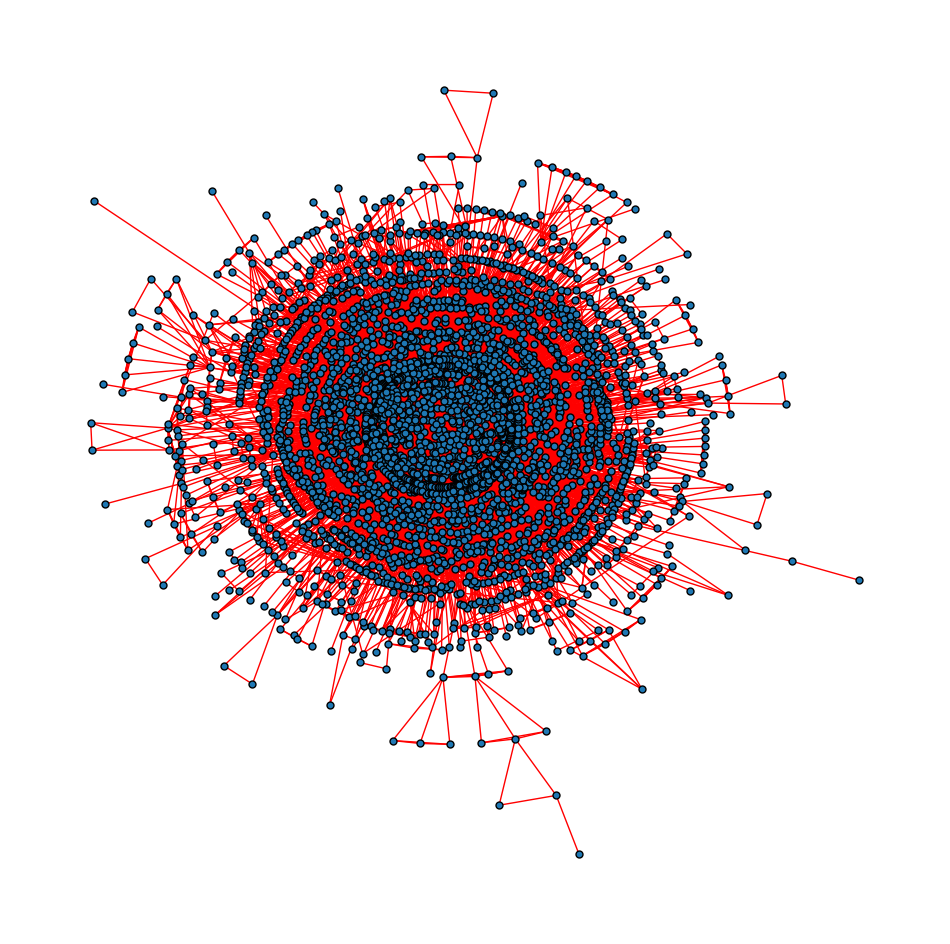

In [8]:
#pos = nx.nx_pydot.graphviz_layout(G_coorg, prog='dot')
plt.figure(figsize=(12, 12))
plt.axis('off')
nx.draw_networkx(G_coorg, pos= nx.kamada_kawai_layout(G_coorg), with_labels=False, node_size=25, edgecolors='black', edge_color='r')
plt.show()

#Compute Metrics

##Degree, Betweenness, PageRank

In [9]:
# Degree Centrality
#degree_centrality = nx.degree_centrality(G_coorg)

weighted_degree = {}
for node in G_coorg.nodes():
    wdeg = sum(data["weight"] for _, _, data in G_coorg.edges(node, data=True))
    weighted_degree[node] = wdeg

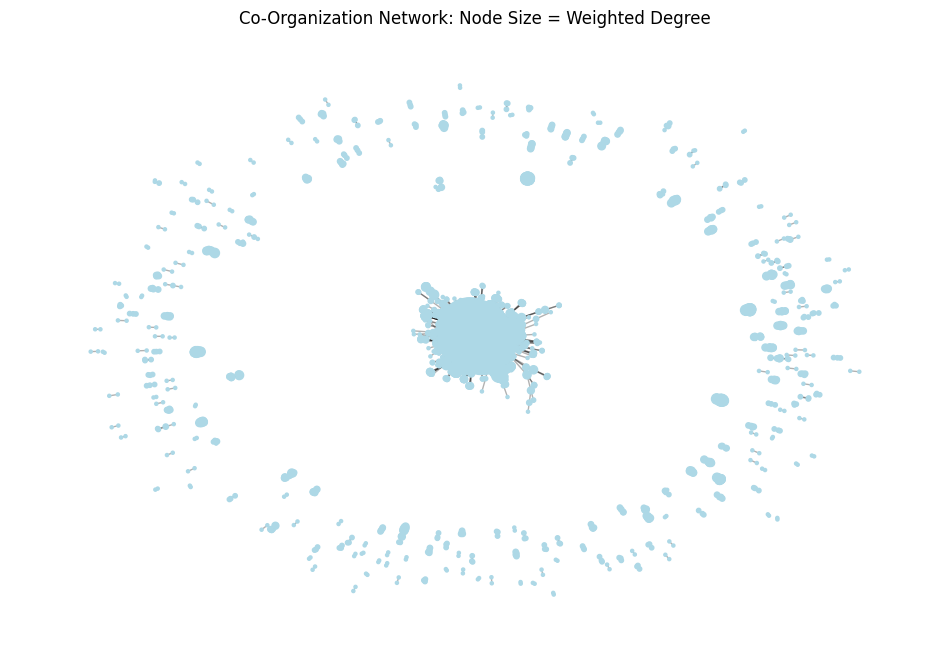

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.spring_layout(G_coorg, seed=42)

# Map weighted degree to node size
sizes = []
for node in G_coorg.nodes():
    wdeg = weighted_degree[node]
    sizes.append(wdeg * 5)  # scale factor

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_coorg, pos, node_size=sizes, node_color="lightblue")
nx.draw_networkx_edges(G_coorg, pos, alpha=0.3)
plt.title("Co-Organization Network: Node Size = Weighted Degree")
plt.axis("off")
plt.show()


<Figure size 1200x800 with 0 Axes>

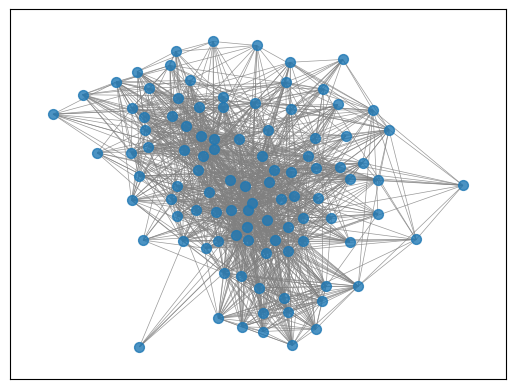

<Figure size 1200x800 with 0 Axes>

In [12]:
# Example: keep only nodes with weighted_degree > 50
nodes_to_keep = [n for n in G_coorg if weighted_degree[n] > 50]
G_sub = G_coorg.subgraph(nodes_to_keep).copy()

pos_sub = nx.spring_layout(G_sub, seed=42)
nx.draw_networkx_nodes(G_sub, pos_sub, node_size=50, alpha=0.8)
nx.draw_networkx_edges(G_sub, pos_sub, edge_color="gray", width=0.5, alpha=0.8)
plt.figure(figsize=(12, 8))


In [13]:
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G_coorg, weight="weight")

In [14]:
# PageRank (choose one) OR Eigenvector Centrality
pagerank = nx.pagerank(G_coorg, weight="weight")
# OR
# eigenvector_centrality = nx.eigenvector_centrality(G_coorg, weight="weight", max_iter=500)

In [15]:
# Convert centralities to DataFrames
df_wdeg = pd.DataFrame(list(weighted_degree.items()), columns=["node", "weighted_degree"])
df_bc = pd.DataFrame(list(betweenness_centrality.items()), columns=["node", "betweenness_centrality"])
df_pr = pd.DataFrame(list(pagerank.items()), columns=["node", "pagerank"])

# If Eigenvector instead of PageRank:
# df_ec = pd.DataFrame(list(eigenvector_centrality.items()), columns=["node", "eigenvector_centrality"])

# Merge them into one DataFrame
df_centralities = df_wdeg.merge(df_bc, on="node").merge(df_pr, on="node")
# If using Eigenvector, merge that as well:
# df_centralities = df_centralities.merge(df_ec, on="node")

# Optional: If your graph nodes have an attribute "name", let's add that too
# e.g., if G_coauthor.nodes[node]["name"] = org_name
names = []
for node in df_centralities["node"]:
    org_name = G_coorg.nodes[node].get("name", str(node))  # fallback to node ID if name missing
    names.append(org_name)
df_centralities["org_name"] = names

# Sort the combined DataFrame by degree centrality (descending)
df_centralities.sort_values("weighted_degree", ascending=False, inplace=True)

# Show top 10 authors by degree centrality
print("\nTop 10 Authors by Degree Centrality:")
print(df_centralities[["org_name", "weighted_degree"]].head(10))

# Show top 10 by betweenness
df_centralities.sort_values("betweenness_centrality", ascending=False, inplace=True)
print("\nTop 10 Authors by Betweenness Centrality:")
print(df_centralities[["org_name", "betweenness_centrality"]].head(10))

# Show top 10 by PageRank
df_centralities.sort_values("pagerank", ascending=False, inplace=True)
print("\nTop 10 Authors by PageRank:")
print(df_centralities[["org_name", "pagerank"]].head(10))

# If you computed Eigenvector Centrality, you can do:
# df_centralities.sort_values("eigenvector_centrality", ascending=False, inplace=True)
# print("\nTop 10 Authors by Eigenvector Centrality:")
# print(df_centralities[["org_name", "eigenvector_centrality"]].head(10))



Top 10 Authors by Degree Centrality:
                                org_name  weighted_degree
25                   Tsinghua University              492
34                   Stanford University              444
47            Carnegie Mellon University              317
10                     Peking University              249
45   The Chinese University of Hong Kong              242
14                       Google Research              226
155             University of Washington              224
27         Shanghai Jiao Tong University              220
220                                  MIT              218
39                    Microsoft Research              201

Top 10 Authors by Betweenness Centrality:
                                org_name  betweenness_centrality
47            Carnegie Mellon University                0.041483
25                   Tsinghua University                0.040572
34                   Stanford University                0.039640
119                 U

In [16]:
# Save to CSV
df_centralities.to_csv("/content/drive/MyDrive/daily-papers-analysis/co_organization/coorg_centralities.csv", index=False)

# Or save to JSON
df_centralities.to_json("/content/drive/MyDrive/daily-papers-analysis/co_organization/coaorg_centralities.json", orient="records")

###Visualization

In [17]:
df_centralities = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/co_organization/coorg_centralities.csv")

# Sort by weighted_degree, pick top 10
df_top_degree = df_centralities.sort_values("weighted_degree", ascending=False).head(10)

# Sort by betweenness_centrality, pick top 10
df_top_betweenness = df_centralities.sort_values("betweenness_centrality", ascending=False).head(10)

# Sort by pagerank, pick top 10
df_top_pagerank = df_centralities.sort_values("pagerank", ascending=False).head(10)

<ipython-input-18-f157c02c9ded>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-18-f157c02c9ded>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-18-f157c02c9ded>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


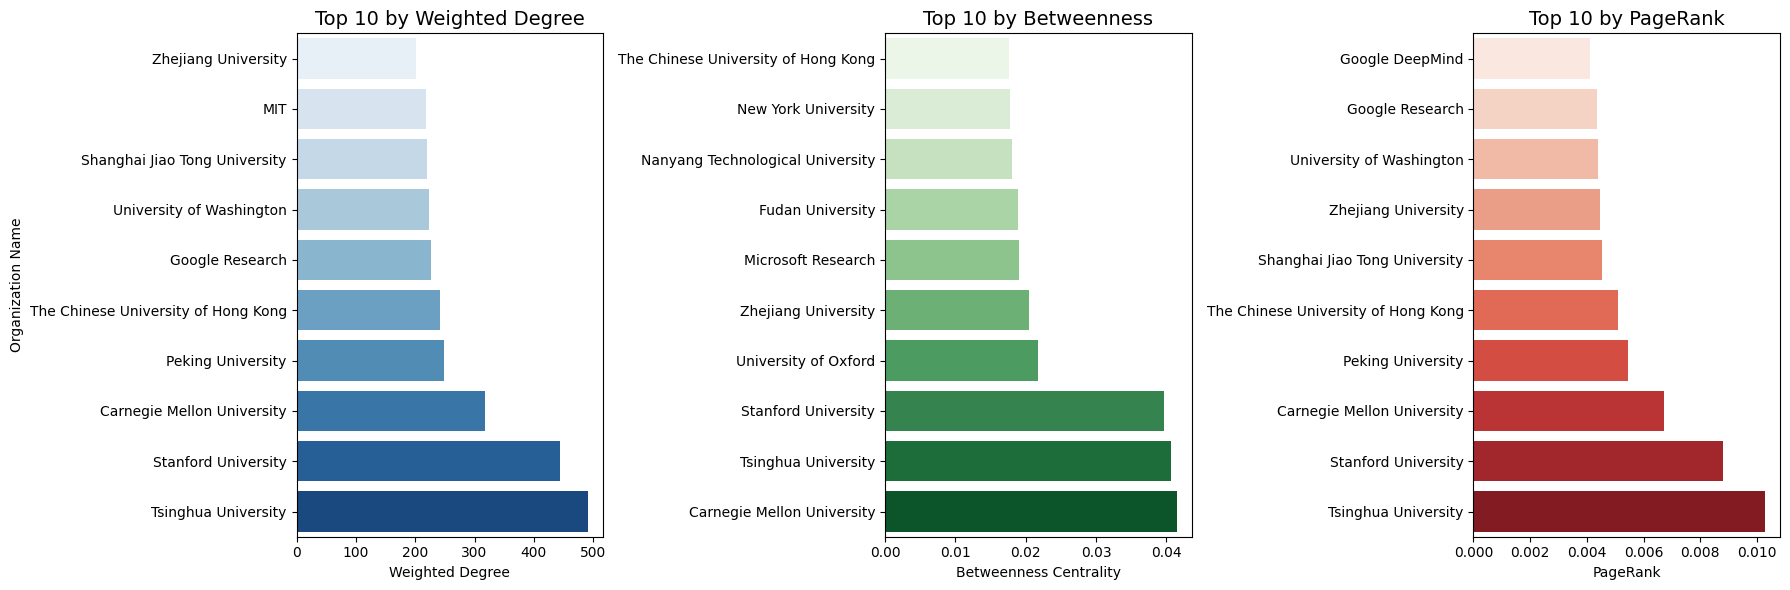

In [18]:
#Side-by-side

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Subplot 1: Weighted Degree ---
sns.barplot(
    data=df_top_degree,
    x="weighted_degree",
    y="org_name",
    palette="Blues_r",
    ax=axes[0]
)
axes[0].set_title("Top 10 by Weighted Degree", fontsize=14)
axes[0].set_xlabel("Weighted Degree")
axes[0].set_ylabel("Organization Name")
axes[0].invert_yaxis()  # put highest at top

# --- Subplot 2: Betweenness Centrality ---
sns.barplot(
    data=df_top_betweenness,
    x="betweenness_centrality",
    y="org_name",
    palette="Greens_r",
    ax=axes[1]
)
axes[1].set_title("Top 10 by Betweenness", fontsize=14)
axes[1].set_xlabel("Betweenness Centrality")
axes[1].set_ylabel("")
axes[1].invert_yaxis()

# --- Subplot 3: PageRank ---
sns.barplot(
    data=df_top_pagerank,
    x="pagerank",
    y="org_name",
    palette="Reds_r",
    ax=axes[2]
)
axes[2].set_title("Top 10 by PageRank", fontsize=14)
axes[2].set_xlabel("PageRank")
axes[2].set_ylabel("")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

<ipython-input-19-66ae3bf39b83>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


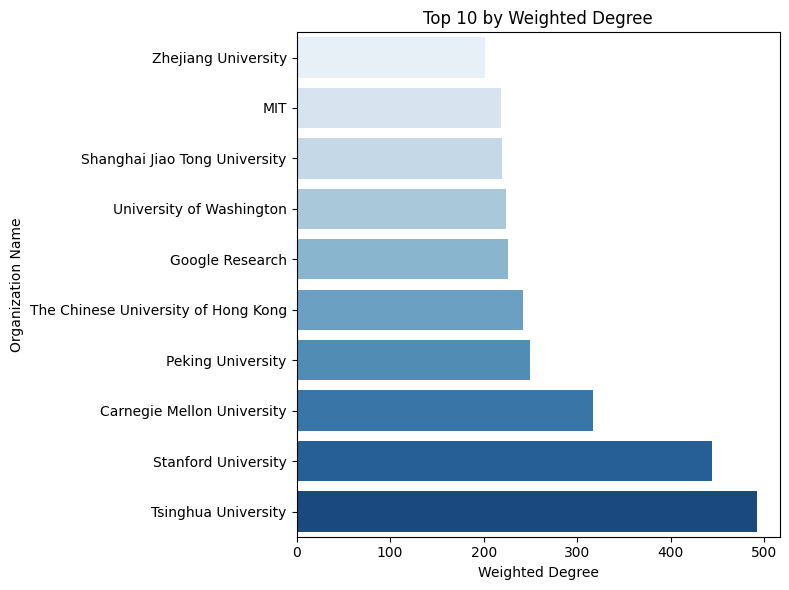

<ipython-input-19-66ae3bf39b83>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


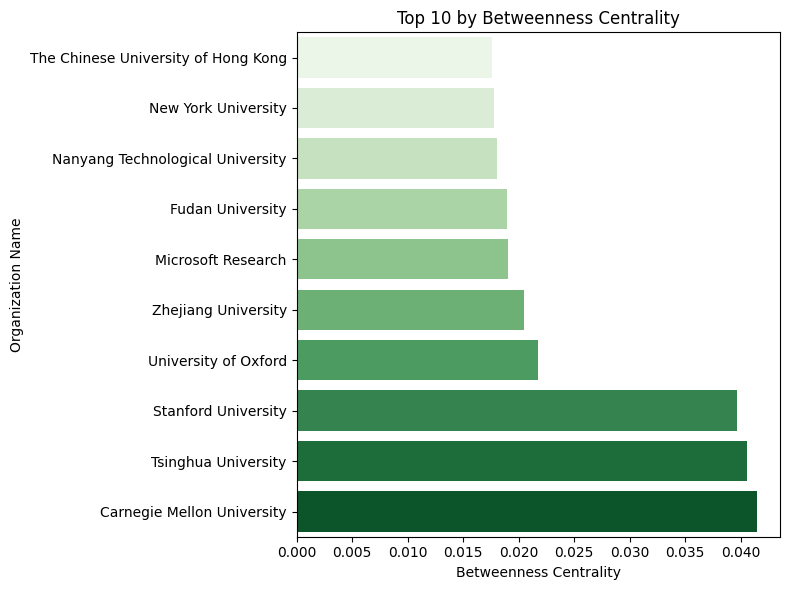

<ipython-input-19-66ae3bf39b83>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


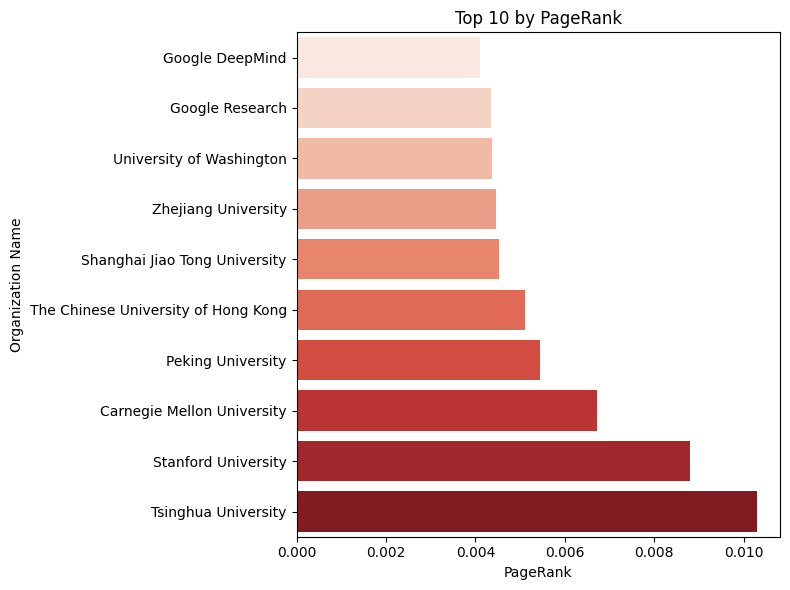

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Weighted Degree (new figure) ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_top_degree,
    x="weighted_degree",
    y="org_name",
    palette="Blues_r"
)
plt.title("Top 10 by Weighted Degree")
plt.xlabel("Weighted Degree")
plt.ylabel("Organization Name")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()

# --- Betweenness (new figure) ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_top_betweenness,
    x="betweenness_centrality",
    y="org_name",
    palette="Greens_r"
)
plt.title("Top 10 by Betweenness Centrality")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Organization Name")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- PageRank (new figure) ---
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_top_pagerank,
    x="pagerank",
    y="org_name",
    palette="Reds_r"
)
plt.title("Top 10 by PageRank")
plt.xlabel("PageRank")
plt.ylabel("Organization Name")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##Modularity

In [20]:
! pip install python-louvain

In [21]:
# Extract the largest connected component
largest_cc = max(nx.connected_components(G_coorg), key=len)
G_lcc = G_coorg.subgraph(largest_cc).copy()

# Find the best partition (dictionary of node -> community_id)
partition = community.best_partition(G_lcc)

# Compute the modularity based on this partition
modularity_value = community.modularity(partition, G_lcc)

print("Modularity of the co-organization network:", modularity_value)

#(above 0.4 or 0.5): The network has distinct clusters where nodes within each cluster are more densely connected than to the rest of the graph.
#(close to 0): The network has weak or no clear community structure.

Modularity of the co-organization network: 0.5948844425126103


##Community

In [22]:
# Convert partition -> CSV
communities_dict = defaultdict(list)
for node, comm_id in partition.items():
    communities_dict[comm_id].append(node)

print("Number of communities:", len(communities_dict))
for cid, members in communities_dict.items():
    print(f"Community {cid}: {len(members)} nodes")

with open("/content/drive/MyDrive/daily-papers-analysis/co_organization/coorg_partition.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["node", "community_id"])
    for node, comm_id in partition.items():
        writer.writerow([node, comm_id])

with open("/content/drive/MyDrive/daily-papers-analysis/co_organization/coorg_communities.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["community_id", "nodes"])
    for cid, members in communities_dict.items():
        nodes_str = ",".join(str(node) for node in members)
        writer.writerow([cid, nodes_str])

print("\nSaved community detection results to:")
print(" - coorg_partition.csv")
print(" - coorg_communities.csv")

Number of communities: 34
Community 28: 223 nodes
Community 1: 232 nodes
Community 6: 215 nodes
Community 3: 620 nodes
Community 5: 157 nodes
Community 24: 154 nodes
Community 8: 97 nodes
Community 19: 47 nodes
Community 13: 50 nodes
Community 32: 123 nodes
Community 14: 93 nodes
Community 25: 43 nodes
Community 16: 55 nodes
Community 17: 143 nodes
Community 2: 32 nodes
Community 27: 52 nodes
Community 10: 139 nodes
Community 30: 48 nodes
Community 31: 29 nodes
Community 33: 5 nodes
Community 4: 17 nodes
Community 7: 20 nodes
Community 9: 26 nodes
Community 11: 9 nodes
Community 12: 6 nodes
Community 0: 7 nodes
Community 15: 4 nodes
Community 18: 7 nodes
Community 20: 4 nodes
Community 21: 19 nodes
Community 22: 8 nodes
Community 23: 3 nodes
Community 26: 6 nodes
Community 29: 5 nodes

Saved community detection results to:
 - coorg_partition.csv
 - coorg_communities.csv


###Visualization

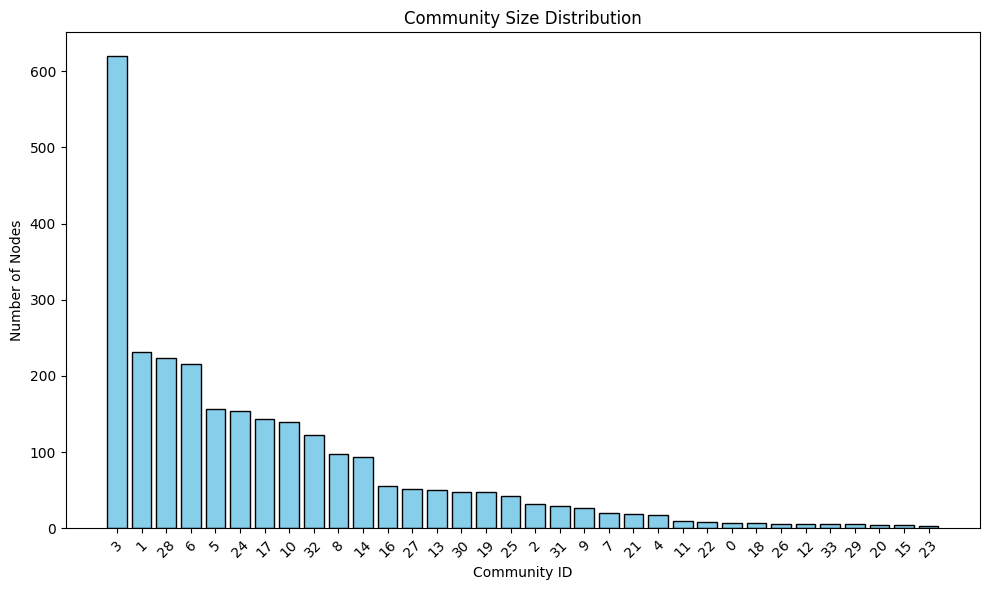

In [24]:
# Load coorg_communities.csv
df_communities = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/co_organization/coorg_communities.csv")

# Each row has community_id and a comma-separated list of nodes
# Compute size by splitting the 'nodes' column
df_communities["size"] = df_communities["nodes"].apply(lambda x: len(str(x).split(",")))

# Sort by size descending
df_communities.sort_values("size", ascending=False, inplace=True)

# Bar chart of community sizes
plt.figure(figsize=(10, 6))
plt.bar(df_communities["community_id"].astype(str), df_communities["size"], color="skyblue", edgecolor="black")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.title("Community Size Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
import csv

df_comm = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/co_organization/coorg_communities.csv")
# Suppose it has columns: ["community_id", "nodes"]

# Convert comma-separated 'nodes' into a list
df_comm["organization_list"] = df_comm["nodes"].apply(lambda x: str(x).split(","))

# Compute the size of each community
df_comm["size"] = df_comm["organization_list"].apply(len)

# Sort by size descending
df_comm.sort_values("size", ascending=False, inplace=True)

top_5_communities = df_comm.head(5).copy()
print(top_5_communities[["community_id", "size"]])

   community_id  size
3             3   620
1             1   232
0            28   223
2             6   215
4             5   157


In [26]:
df_paper_author = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/paper_author.csv")          # [paper_id, author_id]
df_paper_org = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/paper_organization.csv")    # [paper_id, organization_id]
df_org = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/organization.csv")          # [node_id, name]
df_authors = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/author.csv")

In [29]:
def get_papers_for_orgs(org_list, df_paper_org):
    """
    Returns a set of paper_ids for all organizations in 'org_list'.
    """
    # Filter rows where organization_id is in org_list
    subset = df_paper_org[df_paper_org["organization_id"].isin(org_list)]
    return set(subset["paper_id"].unique())

def get_authors_for_papers(paper_ids, df_paper_author):
    """
    Returns a set of author_ids for the given paper_ids.
    """
    subset = df_paper_author[df_paper_author["paper_id"].isin(paper_ids)]
    return set(subset["author_id"].unique())

def get_author_names(author_ids, df_author):
    """
    Returns a list of author names for the given author_ids.
    """
    subset = df_author[df_author["node_id"].isin(author_ids)]
    return subset["name"].unique().tolist()


import pandas as pd

# 1. Read the co-organization communities CSV
df_coorg_communities = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/co_organization/coorg_communities.csv")
# Suppose it has columns: ["community_id", "nodes"]

# 2. Convert comma-separated 'nodes' into a list
df_coorg_communities["org_list"] = df_coorg_communities["nodes"].apply(lambda x: str(x).split(","))

# 3. Compute size if needed
df_coorg_communities["size"] = df_coorg_communities["org_list"].apply(len)

# 4. Sort or pick top communities
df_coorg_communities.sort_values("size", ascending=False, inplace=True)
top_5_communities = df_coorg_communities.head(5)

# Now 'top_5_communities' has a column "org_list" we can use
for idx, row in top_5_communities.iterrows():
    comm_id = row["community_id"]
    orgs_in_comm = row["org_list"]  # This now works
    size = row["size"]

    # Step A: gather paper IDs
    paper_ids = get_papers_for_orgs(orgs_in_comm, df_paper_org)

    # Step B: gather author IDs
    author_ids = get_authors_for_papers(paper_ids, df_paper_author)

    # Step C: get author names
    author_names = get_author_names(author_ids, df_authors)

    print(f"\nCommunity {comm_id} (size={size}) has {len(author_names)} authors:")
    for name in author_names[:10]:
        print("   ", name)




Community 3 (size=620) has 6155 authors:
    Xianzhi Li
    Xiatian Zhu
    Yang Zhao
    Wenbo Zhu
    Chenxiao Liu
    Shuai Lu
    Weizhu Chen
    Daxin Jiang
    Alexey Svyatkovskiy
    Shengyu Fu

Community 1 (size=232) has 2948 authors:
    Xianzhi Li
    Samuel Chan
    Xiaodan Zhu
    Yulong Pei
    Zhiqiang Ma
    Xiaomo Liu
    Sameena Shah
    Chaojian Li
    Sixu Li
    Yang Zhao

Community 28 (size=223) has 4378 authors:
    Ravid Shwartz-Ziv
    Yann LeCun
    Xiaodan Zhu
    Yulong Pei
    Zhiqiang Ma
    Xiaomo Liu
    Sameena Shah
    Yang Zhao
    Da Shen
    Xinyun Chen

Community 6 (size=215) has 2891 authors:
    Yann LeCun
    Ethan Manilow
    Patrick O'Reilly
    Prem Seetharaman
    Bryan Pardo
    Wenqing Wang
    Haosen Yang
    Josef Kittler
    Xiatian Zhu
    Sixu Li

Community 5 (size=157) has 2064 authors:
    Yang Zhao
    Xinyun Chen
    Dawn Song
    Fan Yang
    Zhongyuan Wang
    Youngjoong Kwon
    Dahun Kim
    Duygu Ceylan
    Henry Fuchs
    Xi

In [32]:
community_stats = []

for idx, row in top_5_communities.iterrows():
    comm_id = row["community_id"]
    orgs_in_comm = row["org_list"]  # a list of organization IDs
    # Step A: gather paper IDs
    paper_ids = get_papers_for_orgs(orgs_in_comm, df_paper_org)
    # Step B: gather author IDs
    author_ids = get_authors_for_papers(paper_ids, df_paper_author)

    num_papers = len(paper_ids)
    num_authors = len(author_ids)

    community_stats.append({
        "community_id": comm_id,
        "num_orgs": row["size"],      # how many orgs in this community
        "num_papers": num_papers,
        "num_authors": num_authors
    })

# Convert to a DataFrame for easy viewing
df_stats = pd.DataFrame(community_stats)
df_stats.sort_values("num_orgs", ascending=False, inplace=True)
print(df_stats)


   community_id  num_orgs  num_papers  num_authors
0             3       620        1197         6155
1             1       232         465         2948
2            28       223         728         4378
3             6       215         559         2891
4             5       157         357         2064


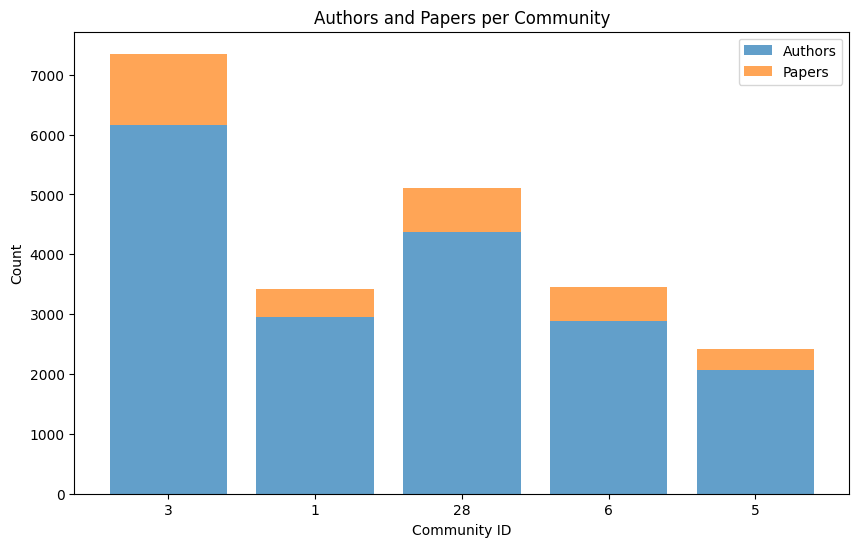

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df_stats["community_id"].astype(str), df_stats["num_authors"], alpha=0.7, label="Authors")
plt.bar(df_stats["community_id"].astype(str), df_stats["num_papers"], alpha=0.7, label="Papers", bottom=df_stats["num_authors"])
plt.xlabel("Community ID")
plt.ylabel("Count")
plt.title("Authors and Papers per Community")
plt.legend()
plt.show()


In [34]:
def get_org_frequency_in_community(org_list, df_paper_org):
    """
    Returns a DataFrame with columns [organization_id, paper_count]
    counting how many papers each organization in org_list appears on.
    """
    # Filter rows where organization_id is in org_list
    subset = df_paper_org[df_paper_org["organization_id"].isin(org_list)]
    # Group by organization_id, count how many unique paper_ids
    freq_df = subset.groupby("organization_id")["paper_id"].nunique().reset_index(name="paper_count")
    # Sort descending
    freq_df.sort_values("paper_count", ascending=False, inplace=True)
    return freq_df
for idx, row in df_coorg_communities.iterrows():
    comm_id = row["community_id"]
    orgs_in_comm = row["org_list"]  # a list of organization IDs
    freq_df = get_org_frequency_in_community(orgs_in_comm, df_paper_org)

    # The top row(s) in freq_df are the most frequent org(s)
    top_org = freq_df.iloc[0]  # if you want just the single top
    print(f"\nCommunity {comm_id} (size={len(orgs_in_comm)})")
    print("Most frequent organization:", top_org["organization_id"])
    print("Paper count:", top_org["paper_count"])



Community 3 (size=620)
Most frequent organization: organization_26
Paper count: 165

Community 1 (size=232)
Most frequent organization: organization_35
Paper count: 152

Community 28 (size=223)
Most frequent organization: organization_15
Paper count: 127

Community 6 (size=215)
Most frequent organization: organization_156
Paper count: 87

Community 5 (size=157)
Most frequent organization: organization_48
Paper count: 142

Community 24 (size=154)
Most frequent organization: organization_24
Paper count: 43

Community 17 (size=143)
Most frequent organization: organization_471
Paper count: 38

Community 10 (size=139)
Most frequent organization: organization_220
Paper count: 16

Community 32 (size=123)
Most frequent organization: organization_136
Paper count: 23

Community 8 (size=97)
Most frequent organization: organization_25
Paper count: 43

Community 14 (size=93)
Most frequent organization: organization_551
Paper count: 20

Community 16 (size=55)
Most frequent organization: organizatio

In [36]:
df_org = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis/GraphDataset/organization.csv")

def get_org_name(org_id, df_org):
    row = df_org[df_org["node_id"] == org_id]
    if len(row) > 0:
        return row.iloc[0]["name"]
    return str(org_id)  # fallback

...

top_org_id = top_org["organization_id"]
top_org_name = get_org_name(top_org_id, df_org)

print("Most frequent organization:", top_org_name)

Most frequent organization: DP Technology


##Global Clustering Coefficient

In [37]:
global_clustering = nx.transitivity(G_coorg)

print("Global Clustering Coefficient (Transitivity):", global_clustering)

Global Clustering Coefficient (Transitivity): 0.28778478335314145


##Scale-free

In [38]:
!pip install powerlaw

In [39]:
import powerlaw

degrees = [deg for _, deg in G_coorg.degree()]

fit = powerlaw.Fit(degrees, discrete=True)
alpha = fit.alpha
xmin = fit.xmin

print(f"Fitted alpha: {alpha}")
print(f"Fitted xmin: {xmin}")

R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Likelihood ratio R: {R}")
print(f"p-value: {p}")

Calculating best minimal value for power law fit
Fitted alpha: 2.0791220244378312
Fitted xmin: 4.0
Likelihood ratio R: 471.042053283315
p-value: 3.1730741481476274e-22


Values less than or equal to 0 in data. Throwing out 0 or negative values


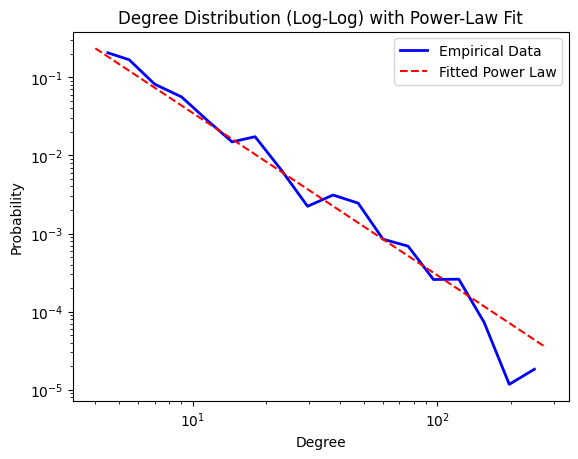

In [40]:
fig = fit.plot_pdf(color='b', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Fitted Power Law')
plt.legend()
plt.title("Degree Distribution (Log-Log) with Power-Law Fit")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

##Clique

In [41]:
all_cliques = list(nx.find_cliques(G_coorg))
print("Number of maximal cliques:", len(all_cliques))

# see the first few cliques:
for i, clique in enumerate(all_cliques[:5]):
    print(f"Clique {i}: {clique}")

largest_clique = max(all_cliques, key=lambda c: len(c))
print("Largest clique (by node count):", largest_clique)
print("Size of the largest clique:", len(largest_clique))

Number of maximal cliques: 4421
Clique 0: ['organization_2012', 'organization_2011']
Clique 1: ['organization_1107', 'organization_1106', 'organization_1105']
Clique 2: ['organization_1330', 'organization_282', 'organization_117', 'organization_448', 'organization_832']
Clique 3: ['organization_3173', 'organization_444', 'organization_3174', 'organization_483', 'organization_3172', 'organization_3175', 'organization_154']
Clique 4: ['organization_146', 'organization_147', 'organization_148']
Largest clique (by node count): ['organization_2120', 'organization_584', 'organization_2126', 'organization_2128', 'organization_747', 'organization_877', 'organization_1023', 'organization_2131', 'organization_64', 'organization_2117', 'organization_2124', 'organization_2135', 'organization_2118', 'organization_2127', 'organization_2136', 'organization_2141', 'organization_2140', 'organization_2129', 'organization_2125', 'organization_299', 'organization_2122', 'organization_835', 'organization_2

In [51]:
# Group by paper_id and count the number of organizations
paper_org_counts = df_paper_org.groupby("paper_id")["organization_id"].count()

# Find the paper_id with the maximum number of organizations
paper_with_max_orgs = paper_org_counts.idxmax()
max_orgs_count = paper_org_counts.max()

print("Paper with the maximum number of organizations:", paper_with_max_orgs)
print("Number of organizations on that paper:", max_orgs_count)

Paper with the maximum number of organizations: paper_2229
Number of organizations on that paper: 49


In [53]:
# Find paper with the max organizations
paper_org_counts = df_paper_org.groupby("paper_id")["organization_id"].count()
paper_with_max_orgs = paper_org_counts.idxmax()
max_orgs_count = paper_org_counts.max()

print("Paper with the maximum number of organizations:", paper_with_max_orgs)
print("Number of organizations on that paper:", max_orgs_count)

# Get all organization IDs for that paper
subset = df_paper_org[df_paper_org["paper_id"] == paper_with_max_orgs]
org_ids = subset["organization_id"].unique()

# Look up each organization's name in df_org
df_org_sub = df_org[df_org["node_id"].isin(org_ids)]
org_names = df_org_sub["name"].unique()

# Print the organization names
print("\nOrganizations on this paper:")
for name in org_names:
    print("  ", name)


Paper with the maximum number of organizations: paper_2229
Number of organizations on that paper: 49

Organizations on this paper:
   New York University
   Google Research
   Stanford University
   Microsoft Research
   National University of Singapore
   Intel Labs
   Google
   University of Oxford
   Virginia Tech
   MIT
   Adobe
   Meta
   The Ohio State University
   NVIDIA
   Intel
   Polytechnique Montreal
   University of Trento
   Caltech
   Cerebras Systems
   University of York
   UMass Amherst
   Lawrence Livermore National Laboratory
   Center for Security and Emerging Technology
   LF AI & Data
   Nike
   Commn Ground
   FAIR, Meta
   DFKI & Hessian.AI
   Qualcomm Technologies, Inc.
   Coactive AI
   Digital Safety Research Institute
   Consumer Reports
   Ethriva
   Public Authority for Applied Education and Training of Kuwait
   Nebius AI
   Project Humanit.ai
   Nutanix
   RAND
   Illinois Institute of Technology
   Credo AI
   Vijil
   UCSB
   TU Eindhoven
   IIT Delh

Organizations on that paper: {'organization_584', 'organization_2126', 'organization_2128', 'organization_747', 'organization_877', 'organization_1023', 'organization_64', 'organization_2117', 'organization_2124', 'organization_2131', 'organization_2135', 'organization_2118', 'organization_2127', 'organization_2136', 'organization_2140', 'organization_2141', 'organization_2129', 'organization_2125', 'organization_299', 'organization_2122', 'organization_835', 'organization_2138', 'organization_2123', 'organization_2120', 'organization_2130', 'organization_1230', 'organization_2134', 'organization_2116', 'organization_2137', 'organization_221', 'organization_2119', 'organization_200', 'organization_951', 'organization_2133', 'organization_275', 'organization_35', 'organization_2', 'organization_2139', 'organization_15', 'organization_2115', 'organization_2121', 'organization_40', 'organization_2132', 'organization_76', 'organization_72', 'organization_555', 'organization_717', 'organiza

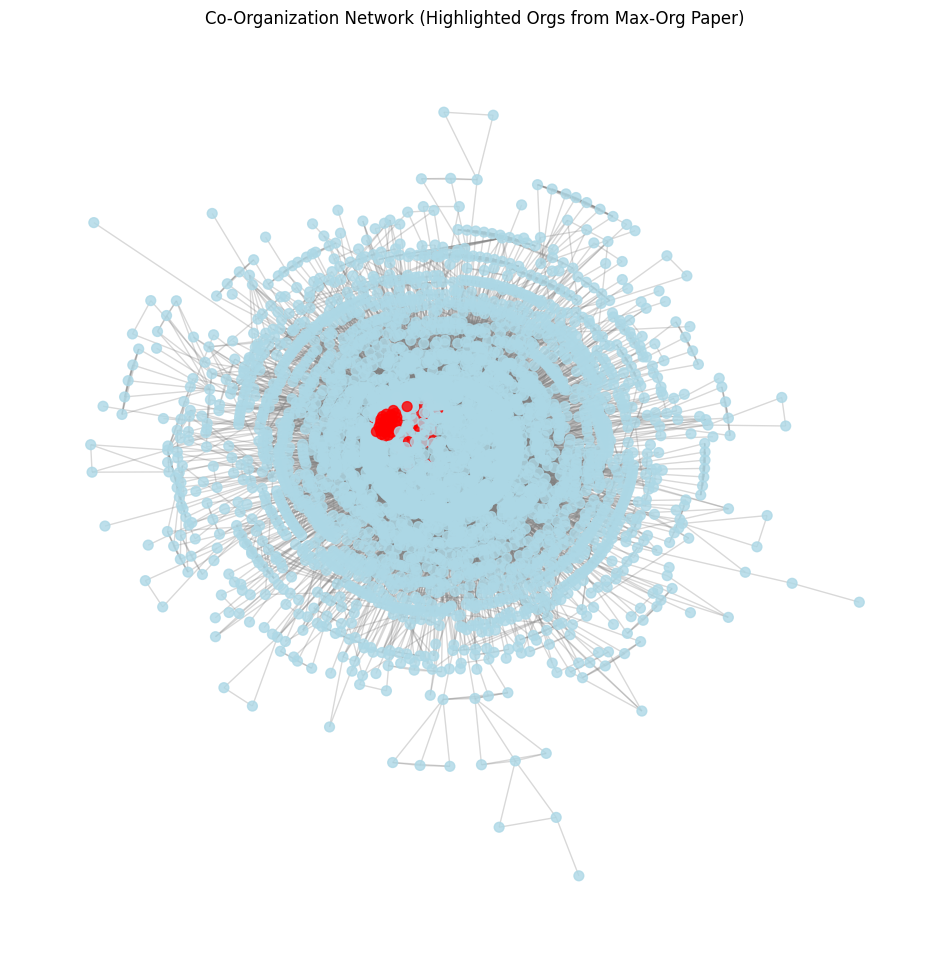

In [58]:
# 1. Find paper with the maximum number of organizations
paper_org_counts = df_paper_org.groupby("paper_id")["organization_id"].count()
paper_with_max_orgs = paper_org_counts.idxmax()

# 2. Extract the org IDs from that paper
subset = df_paper_org[df_paper_org["paper_id"] == paper_with_max_orgs]
org_ids_to_highlight = set(subset["organization_id"].unique())
print("Organizations on that paper:", org_ids_to_highlight)

# 1. Find paper with the maximum number of organizations
paper_org_counts = df_paper_org.groupby("paper_id")["organization_id"].count()
paper_with_max_orgs = paper_org_counts.idxmax()

# 2. Extract the org IDs from that paper
subset = df_paper_org[df_paper_org["paper_id"] == paper_with_max_orgs]
org_ids_to_highlight = set(subset["organization_id"].unique())
print("Organizations on that paper:", org_ids_to_highlight)


import matplotlib.pyplot as plt
import networkx as nx

# Suppose G_coorg is your co-organization graph
# We'll create a color array. If node in org_ids_to_highlight -> 'red', else 'lightblue'.
node_colors = []
for node in G_coorg.nodes():
    if node in org_ids_to_highlight:
        node_colors.append("red")
    else:
        node_colors.append("lightblue")

# Choose a layout
pos = nx.kamada_kawai_layout(G_coorg)

plt.figure(figsize=(12, 12))
plt.title("Co-Organization Network (Highlighted Orgs from Max-Org Paper)")

# Draw nodes with the color array
nx.draw_networkx_nodes(
    G_coorg, pos,
    node_size=50,
    node_color=node_colors,
    alpha=0.8
)

# Draw edges
nx.draw_networkx_edges(
    G_coorg, pos,
    edge_color="gray",
    alpha=0.3
)

# (Optional) Draw labels if you want to see organization names
# labels = {n: G_coorg.nodes[n].get("name", n) for n in G_coorg.nodes()}
# nx.draw_networkx_labels(G_coorg, pos, labels, font_size=6)

plt.axis("off")
plt.show()



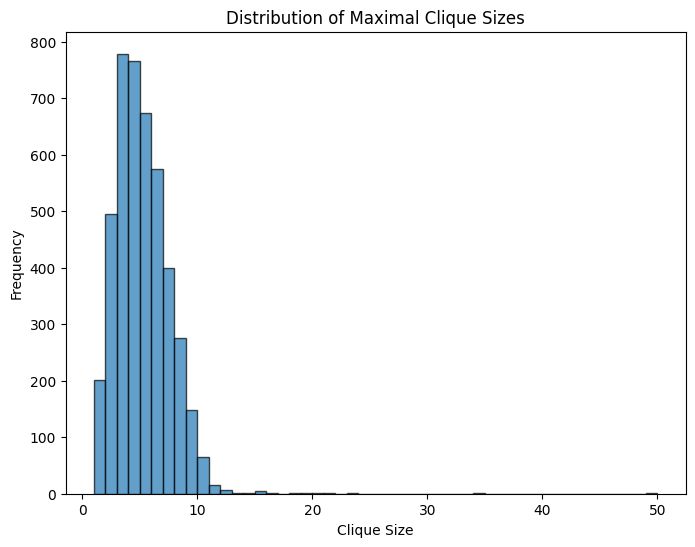

In [50]:
# Suppose 'all_cliques' is your list of maximal cliques
clique_sizes = [len(c) for c in all_cliques]

plt.figure(figsize=(8,6))
plt.hist(clique_sizes, bins=range(1, max(clique_sizes)+2), edgecolor='black', alpha=0.7)
plt.xlabel("Clique Size")
plt.ylabel("Frequency")
plt.title("Distribution of Maximal Clique Sizes")
plt.show()


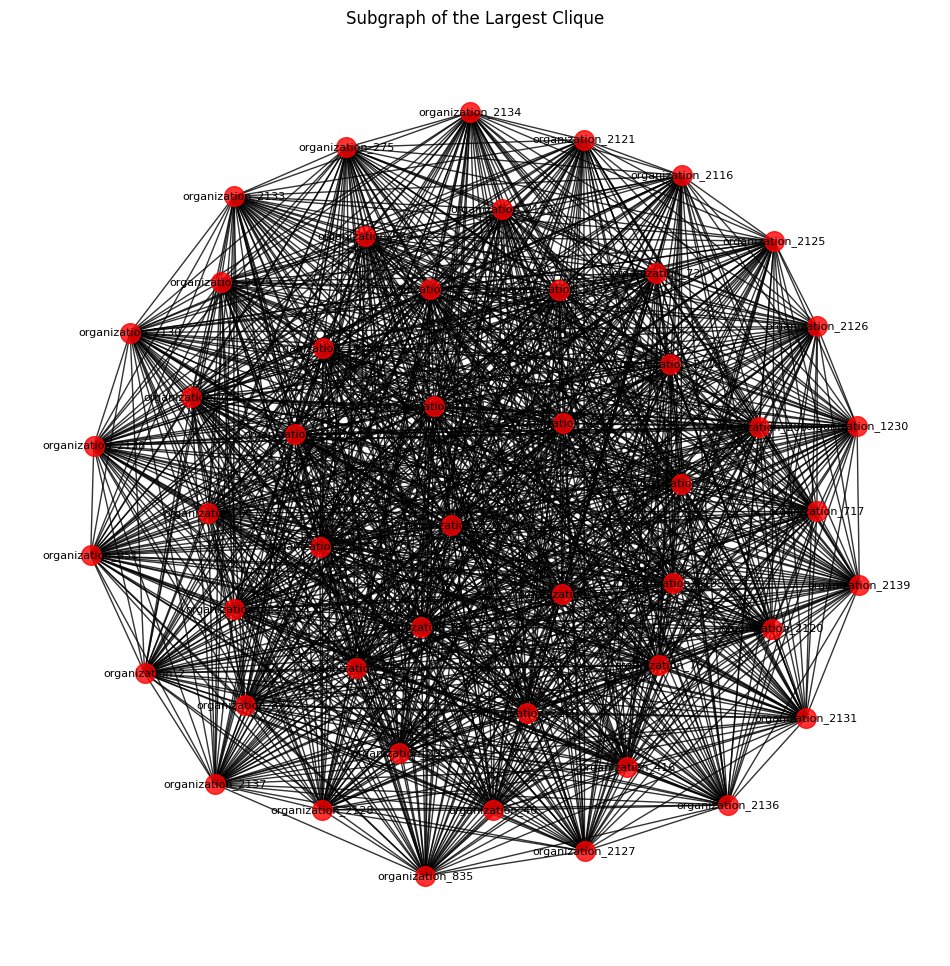

In [49]:
import networkx as nx
import matplotlib.pyplot as plt

largest_clique = max(all_cliques, key=len)
clique_subgraph = G_coorg.subgraph(largest_clique).copy()

pos = nx.spring_layout(clique_subgraph, seed=42)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(clique_subgraph, pos, node_color='red', node_size=200, alpha=0.8)
nx.draw_networkx_edges(clique_subgraph, pos, edge_color='black', width=1.0, alpha=0.8)
nx.draw_networkx_labels(clique_subgraph, pos, font_size=8)
plt.title("Subgraph of the Largest Clique")
plt.axis('off')
plt.show()


Another visualization

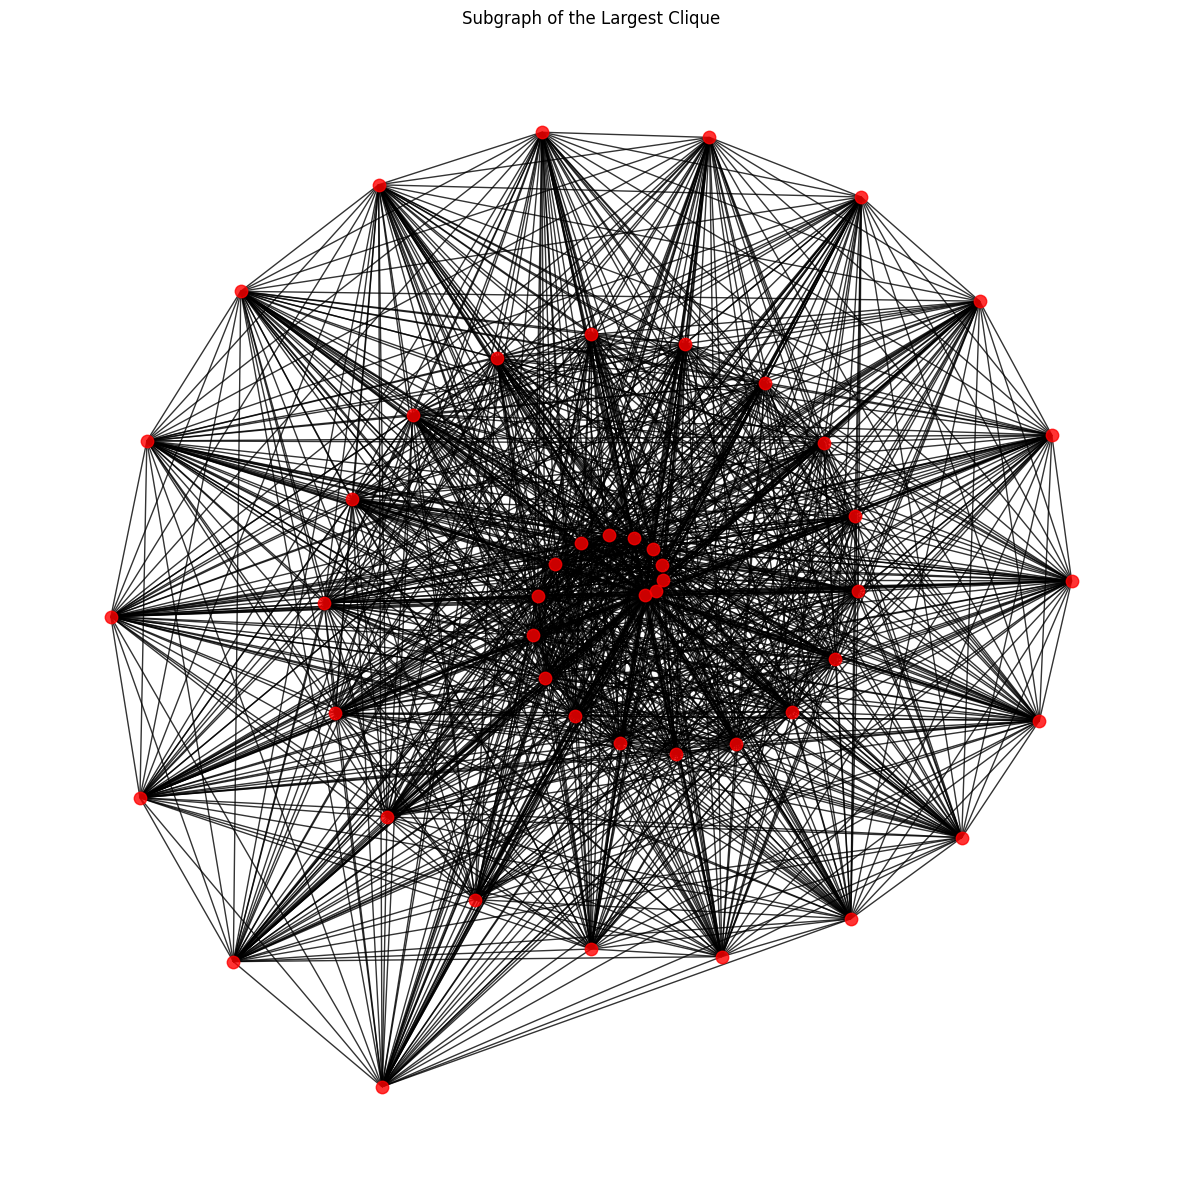

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

# Identify largest clique and build subgraph
largest_clique = max(all_cliques, key=len)
clique_subgraph = G_coorg.subgraph(largest_clique).copy()

# Try a different layout if you want:
#pos = nx.kamada_kawai_layout(clique_subgraph)
#pos = nx.spring_layout(clique_subgraph, seed=42)
pos = nx.spiral_layout(clique_subgraph)

plt.figure(figsize=(15, 15))
plt.title("Subgraph of the Largest Clique")

# 1. Draw edges first (darker color, thicker, partially opaque)
nx.draw_networkx_edges(
    clique_subgraph, pos,
    edge_color="black",
    width=1.0,
    alpha=0.8
)

# 2. Draw nodes (smaller, partially transparent)
nx.draw_networkx_nodes(
    clique_subgraph, pos,
    node_color="red",
    node_size=80,
    alpha=0.8
)

# 3. (Optional) Draw labels, but this can get cluttered if there are many nodes
#    Uncomment if you really need them:
# nx.draw_networkx_labels(clique_subgraph, pos, font_size=6)

plt.axis("off")
plt.show()
